In [1]:
"""
python 3.7
This file trains a 2-or-4 people face classifier on top of the FaceNet extracted embeddings and compares the result to k-nn classifier.
The conclusions from the experiemnts is the following:
    - Deep NN classifier trained on top of the embeddings improves classification accuracy from 0.85-0.89 for knn to 0.92-0.95
The network architecture was tuned to achieve this accuracy improvement.
"""

from collections import defaultdict, Counter
import glob
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import scipy
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def load_embeddings(path, names=None):
    embeddings = []
    for user_embedding in glob.glob(path):
        if names:
            found_names = [name in user_embedding for name in names]
            if not any(found_names):
                continue
        with open(user_embedding, 'rb') as embed_file:
            user_info = pickle.load(embed_file, encoding='latin1')
            for user in user_info:
                embeddings.append(user)
    return embeddings

In [4]:
def get_users(embeddings):
    users = set()
    for emb in embeddings:
        if emb["name"] not in users:
            users.add(emb["name"])
    return sorted(list(users))

In [5]:
def create_dataset(embeddings, user_labels):
    x = []
    y = []
    for emb in embeddings:
        x.append(emb['embedding'].flatten())
        y.append(user_labels[emb["name"]])
    return np.array(x), np.array(y)

In [6]:
# Two-people classifier
#embeddings = load_embeddings("face_embeddings/*.emb", names={"amanosan", "person2"})
# Four-people classifier
embeddings = load_embeddings("face_embeddings/*.emb", names={"amanosan", "uedasan", "person1", "person2"})
users = get_users(embeddings)
user_labels = {name: idx for idx, name in enumerate(users)}
print(users)
print(user_labels)

['amanosan', 'person1', 'person2', 'uedasan']
{'amanosan': 0, 'person1': 1, 'person2': 2, 'uedasan': 3}


In [7]:
# prepare data
x, y = create_dataset(embeddings, user_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
def create_model(input_dim, output_dim, hidden_dim=128):
    layers = [
        tkl.Dense(hidden_dim, input_dim=input_dim),
        tkl.BatchNormalization(),
        tkl.ReLU(),
        tkl.Dense(hidden_dim, input_dim=input_dim),
        tkl.BatchNormalization(),
        tkl.ReLU(),
        tkl.Dense(output_dim, activation='linear'),
    ]
    model = tk.Sequential(layers)
    
    model.compile(optimizer='sgd', loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True))
    #model.compile(optimizer='rmsprop', loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True))
    return model

In [9]:
model = create_model(input_dim=x.shape[1], output_dim=len(users))
callbacks = [
    tk.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.000, verbose=1),
    tk.callbacks.ModelCheckpoint('face_model/', monitor='val_loss', save_best_only=True),
    tk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-4, patience=3)
]

history = model.fit(x_train, y_train, batch_size=8, epochs=200, validation_split=0.1, callbacks=callbacks)

Epoch 1/200
 66/123 [===============>..............] - ETA: 0s - loss: 0.9506WARNING:tensorflow:From /home/ivan/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: face_model/assets
123/123 [==============================] - 1s 7ms/step - loss: 0.8340 - val_loss: 1.1656 - lr: 0.0100
Epoch 2/200
123/123 [==============================] - 1s 6ms/step - loss: 0.5349 - val_loss: 0.9217 - lr: 0.0100
Epoch 3/200
123/123 [==============================] - 1s 7ms/step - loss: 0.4763 - val_loss: 0.6180 - lr: 0.0100
Epoch 4/200
123/123 [==============================] - 1s 6ms/step - loss: 0.3809 - val_loss: 0.3942 - lr: 0.0100
Epoch 5/200
123/123 [============================

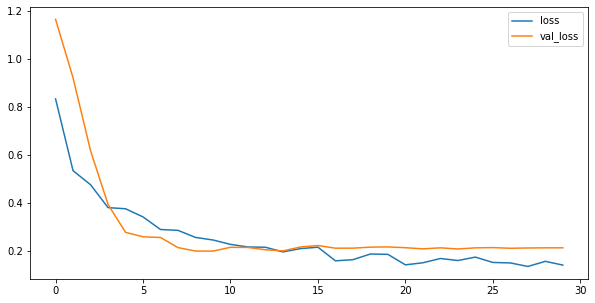

In [10]:
loss_plt, = plt.plot(history.history["loss"], label='loss')
val_loss_plt, = plt.plot(history.history["val_loss"], label='val_loss')
plt.legend(handles=[loss_plt, val_loss_plt])

Accuracy 0.9197080291970803, precision 0.9197080291970803, recall 0.9197080291970803


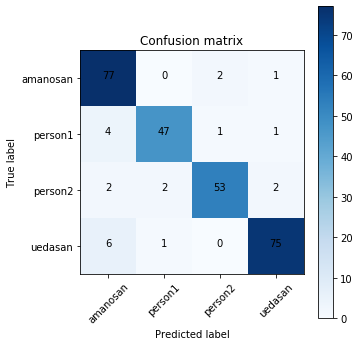

In [11]:
restored_model = tk.models.load_model('face_model/')

# export this model in TF 1 format
model_filename = "_".join(users)
restored_model.save_weights(f'face_model/{model_filename}_weights.h5')

y_hat_logits = restored_model.predict(x_test)
y_hat = np.argmax(y_hat_logits, axis=1)
accuracy = accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat, average='micro')
recall = recall_score(y_test, y_hat, average='micro')
cm = confusion_matrix(y_test, y_hat)
print(f"Accuracy {accuracy}, precision {precision}, recall {recall}")
plot_confusion_matrix(cm, users)

{'ivan': 0, 'shubham': 1}
Accuracy 0.6012793176972282, precision 0.6012793176972282, recall 0.6012793176972282


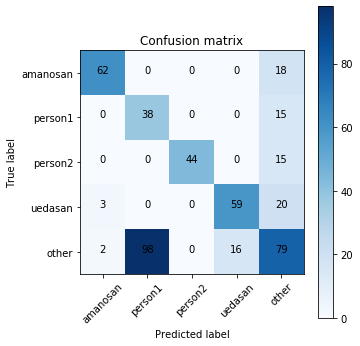

In [12]:
# Select a threshold for rejecting unregistered people
# if there is no embedding above a certain confidence, then assign it other label
th = 0.9
other_embeddings = load_embeddings("face_embeddings/*.emb", names={"ivan", "shubham"})
other_users = get_users(other_embeddings)
other_user_labels = {name: idx for idx, name in enumerate(other_users)}
print(other_user_labels)
x_other, y_other = create_dataset(other_embeddings, other_user_labels)
y_other[:] = other_label = len(user_labels)  # assign single label to all other people
# combine test and other datasets
x_test_other = np.vstack((x_test, x_other))
y_test_other = np.concatenate((y_test, y_other))
y_hat_logits = restored_model.predict(x_test_other)
y_hat_softmax = tf.math.softmax(y_hat_logits, axis=1)
y_hat_softmax_max = np.max(y_hat_softmax, axis=1)
y_hat = np.argmax(y_hat_logits, axis=1)
y_hat[y_hat_softmax_max < th] = other_label

# plotting
accuracy = accuracy_score(y_test_other, y_hat)
precision = precision_score(y_test_other, y_hat, average='micro')
recall = recall_score(y_test_other, y_hat, average='micro')
cm = confusion_matrix(y_test_other, y_hat)
print(f"Accuracy {accuracy}, precision {precision}, recall {recall}")
plot_confusion_matrix(cm, users + ['other'])

In [13]:
# Get same result from nearest neighbours
def distance(e1, e2):
    return np.min(np.linalg.norm(np.subtract(np.array(e1), np.array(e2))))  # Euclidian distance

In [14]:
def calculate_distance(x_train, x_test):
    distances = [[0] * len(x_train) for _ in range(len(x_test))]
    for i, test_embedding in enumerate(x_test):
        for j, train_embedding in enumerate(x_train):
            distances[i][j] = distance(test_embedding, train_embedding)
    distances = np.array(distances)
    return distances

In [15]:
def knn_predict(th, distances, y_train, neighbours=1):
    y_hat = np.empty(distances.shape[0])
    rejected = np.ones(distances.shape[0], dtype=np.bool)  # initially mark all as rejected
    for i in range(len(distances)):
        dist = distances[i]
        min_distance_top_n_idxs = np.argpartition(dist, neighbours)[:neighbours]
        neighbour_classes = y_train[min_distance_top_n_idxs]
        neighbour_counts_per_class = Counter(neighbour_classes)
        highest_frequency = max(neighbour_counts_per_class.values())
        most_frequent_classes = {name for name, counts in neighbour_counts_per_class.items() if counts == highest_frequency}
        if len(most_frequent_classes) > 1:
            # when there are several winners (several faces with the same number of counts),
            # select the name with the smallest average distance
            class_dist = defaultdict(float)
            for top_n_idx, top_n_name in enumerate(neighbour_classes):
                if top_n_name in most_frequent_classes:
                    class_dist[top_n_name] += dist[min_distance_top_n_idxs[top_n_idx]]
            best_name, best_distance = min(class_dist.items(), key=lambda x: x[1])
            best_distance /= highest_frequency
        else:
            # when there is a single winner, select the smallest distance as best_distance
            best_name = most_frequent_classes.pop()
            best_name_idx = min_distance_top_n_idxs[neighbour_classes == best_name][0]
            best_distance = dist[best_name_idx]

        if best_distance < th:
            y_hat[i] = best_name
            rejected[i] = False
    return y_hat, rejected

In [16]:
distances = calculate_distance(x_train, x_test)
y_hat, rejected = knn_predict(0.95, distances, y_train, neighbours=4)

Accuracy 0.8795620437956204, precision 0.8795620437956204, recall 0.8795620437956204


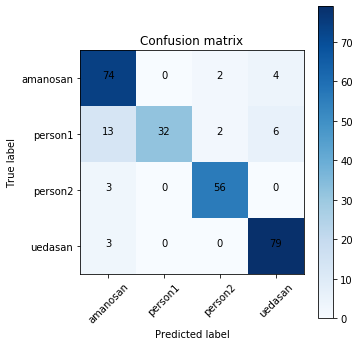

In [17]:
y_hat_wo_rejected = y_hat[rejected == False]
y_test_wo_rejected = y_test[rejected == False]
accuracy = accuracy_score(y_test_wo_rejected, y_hat_wo_rejected)
precision = precision_score(y_test_wo_rejected, y_hat_wo_rejected, average='micro')
recall = recall_score(y_test_wo_rejected, y_hat_wo_rejected, average='micro')
cm = confusion_matrix(y_test_wo_rejected, y_hat_wo_rejected)
print(f"Accuracy {accuracy}, precision {precision}, recall {recall}")
plot_confusion_matrix(cm, users)